# BRAN2020 daily ARD

Date: 15 December, 2023

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is 16TB of data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [2]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#more plotting
import matplotlib.dates as mdates
#import seaborn as sns

In [3]:
xr.__version__

'2024.1.1'

#### start a local Dask client

In [4]:
from dask.distributed import Client
#client = Client(threads_per_worker=1)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45023,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:39373,Total threads: 4
Dashboard: /proxy/37757/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:45471,


#### ignore warnings

In [5]:
import warnings
warnings.filterwarnings('ignore')

# ARD workflow

### read paths from config file

#### [ you will need to specifiy your correct path for the `data-catalogue/config.ini` file ]

In [6]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config file
#########
#### you will need to specifiy your correct path the the `data-catalogue/config.ini` file 
#########
config.read('./code/BRAN2020-intake-catalog/config.ini')

# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')

In [7]:
catalog_path

'/g/data/v14/tm4888/code/BRAN2020-intake-catalog/catalogs/'

In [8]:
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [9]:
BRAN2020_catalog

,unique
source,1
domain,4
time_period,4
variable,142
path,8949
derived_variable,0


In [10]:
BRAN2020_catalog.unique()['source']

['BRAN2020']

In [11]:
BRAN2020_catalog.unique()['domain']

['atm', 'ice', 'ocean', 'grid']

In [12]:
BRAN2020_catalog.unique()['time_period']

['annual', 'daily', 'month', 'static']

In [13]:
var_list = BRAN2020_catalog.unique()['variable']
var_list.sort()
df = pd.DataFrame(var_list, columns=['BRAN2020 Variables'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

        BRAN2020 Variables
0                  angle_C
1                  angle_E
2                  angle_N
3                  angle_T
4                   area_C
5                   area_E
6                   area_N
7                   area_T
8                    bmf_u
9                    bmf_v
10                 depth_t
11              ds_00_01_C
12              ds_00_01_E
13              ds_00_01_N
14              ds_00_01_T
15              ds_00_02_C
16              ds_00_02_E
17              ds_00_02_N
18              ds_00_02_T
19              ds_00_10_C
20              ds_00_10_E
21              ds_00_10_N
22              ds_00_10_T
23              ds_00_20_C
24              ds_00_20_E
25              ds_00_20_N
26              ds_00_20_T
27              ds_01_02_C
28              ds_01_02_E
29              ds_01_02_N
30              ds_01_02_T
31              ds_01_11_C
32              ds_01_11_E
33              ds_01_11_N
34              ds_01_11_T
35              ds_01_21_C
3

In [14]:
search = BRAN2020_catalog.search(variable=['temp'],time_period='daily')

In [15]:
search.unique()['variable']

['temp']

In [16]:
search

,unique
source,1
domain,1
time_period,1
variable,1
path,366
derived_variable,0


In [17]:
search.df

,source,domain,time_period,variable,path
0,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_199...
1,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_199...
2,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_199...
3,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_199...
4,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_199...
...,...,...,...,...,...
361,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_202...
362,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_202...
363,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_202...
364,BRAN2020,ocean,daily,[temp],/g/data/gb6/BRAN/BRAN2020/daily/ocean_temp_202...


### Out of some 9000 files we now have narrowed down the just the 366 that have the information we need

### We can now load all that data into a single 11TB "lazy" `xarray` object for further reduction and analysis

In [18]:
%%time
xarray_open_kwargs = {"chunks": {"time": 1, "st_ocean": 51, "xt_ocean": 3600, "yt_ocean": 300}}
DS=search.to_dask(xarray_open_kwargs=xarray_open_kwargs)

CPU times: user 3.63 s, sys: 432 ms, total: 4.06 s
Wall time: 13.3 s


In [19]:
DS

<xarray.Dataset>
Dimensions:   (Time: 11138, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * Time      (Time) datetime64[ns] 1993-01-01T12:00:00 ... 2023-06-30T12:00:00
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 51, 300, 3600), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    grid_type:                       regular
    grid_tile:                       N/A
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    title:                           BRAN2020
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:domain:         ocean
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       temp
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          ocean.daily

In [20]:
DS.nbytes/1e9

12269.620930312

## ARD - write zarr & chunk & write zarr

In [21]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-daily-temp-v15122023.zarr'

In [ ]:
%%time
DS.to_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# ----- Client(threads_per_worker=1) -------
# CPU times: user 2min 26s, sys: 29.9 s, total: 2min 56s
# Wall time: 13min 1s
# ----- Client() -------
# CPU times: user 1min 53s, sys: 18.1 s, total: 2min 11s
# Wall time: 14min 3s

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/finished_BRAN2020-daily-temp.log

## RELOAD in ARD collection (note storage only 2.1TB)

In [22]:
BRAN2020_daily_temp = xr.open_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)

In [23]:
BRAN2020_daily_temp

<xarray.Dataset>
Dimensions:   (Time: 11138, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * Time      (Time) datetime64[ns] 1993-01-01T12:00:00 ... 2023-06-30T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 51, 300, 3600), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       temp
    intake_esm_dataset_key:          ocean.daily
    intake_esm_vars:                 ['temp']
    title:                           BRAN2020

# sanity check 

In [24]:
%%time
result = BRAN2020_daily_temp.temp.mean(['st_ocean','yt_ocean','xt_ocean']).compute()

CPU times: user 12min 26s, sys: 1min 40s, total: 14min 7s
Wall time: 45min 30s


Text(0.5, 1.0, 'global average ocean temp \n (volume averaging is approximate)')

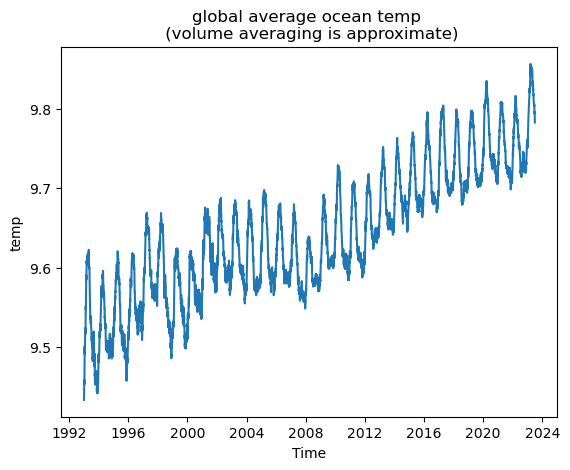

In [28]:
result.plot()
plt.title('global average ocean temp \n (volume averaging is approximate)')

## CHUNK for time and WRITE zarr

### "Consider either rechunking using `chunk()`, deleting or modifying `encoding['chunks']`"

In [29]:
def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [30]:
ard_rcTime_file_ID = 'BRAN2020-daily-temp-chunk4time-v02022024.zarr'

In [33]:
BRAN2020_daily_temp_rcTime =  BRAN2020_daily_temp.chunk({'Time':-1,'st_ocean':-1,'xt_ocean':1,'yt_ocean':100})
BRAN2020_daily_temp_rcTime

<xarray.Dataset>
Dimensions:   (Time: 11138, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * Time      (Time) datetime64[ns] 1993-01-01T12:00:00 ... 2023-06-30T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(11138, 51, 100, 1), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       temp
    intake_esm_dataset_key:          ocean.daily
    intake_esm_vars:                 ['temp']
    title:                           BRAN2020

In [34]:
BRAN2020_daily_temp_rcTime = remove_zarr_encoding(BRAN2020_daily_temp_rcTime)

In [ ]:
%%time
BRAN2020_daily_temp_rcTime.to_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)

2024-02-02 11:26:15,308 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:39373 -> tcp://127.0.0.1:44131
Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/distributed/worker.py", line 1780, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/finished_timechunk.log

## end ARD workflow $\Uparrow$

# begin post-processing workflow $\Downarrow$

## load in both zarr collections

In [ ]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023.zarr'
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [ ]:
temp_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
temp_chunked = xr.open_zarr(BRAN2020_ard_path + ard_file_ID,consolidated=True)

## basic functions

In [ ]:
def get_monthly_climatology(xr_object,time_coord_name = 'time',flox=True):
    if flox == True:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    else:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True)
    return monthly_climatology

def get_monthly_anomaly(xr_object,monthly_climatology, time_coord_name = 'time'):
    monthly_anomaly = xr_object.groupby(time_coord_name+'.month') - monthly_climatology
    return monthly_anomaly


# Climatology

In [ ]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology

In [ ]:
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

In [ ]:
%%time
temp_monthly_climatology = temp_monthly_climatology.compute()

# CPU times: user 32.1 s, sys: 17.9 s, total: 49.9 s
# Wall time: 2min 20s
#

# Anomaly

In [ ]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')

In [ ]:
temp_anomaly

# define El Nino and La Nina using NCAR ONI data

In [ ]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [ ]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)
ONI_DF

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['El Nino'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI El Nino events') 
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['La Nina'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI La Nina events') 
plt.show()

## heatmap

### make table for average over certain region

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_ONI_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_ONI_anomaly = spatial_mean_of_ONI_anomaly.compute()

In [ ]:
spatial_mean_of_ONI_anomaly.plot()

In [ ]:
spatial_mean_of_ONI_anomaly_DF = spatial_mean_of_ONI_anomaly.to_dataframe()
spatial_mean_of_ONI_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_ONI_anomaly_DF.index).year
spatial_mean_of_ONI_anomaly_DF

In [ ]:
heatmap_data = spatial_mean_of_ONI_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

In [ ]:
heatmap_data

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region')
plt.show()

## stacked heatmap plot

In [ ]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [ ]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

#### count of events in BRAN2020 period
El Nino = 8 events ( weak - strong ) as defined by ONI<br>
La Nina = 10 events ( weak - strong ) as defined by ONI <br>
El Nino months total = 70 = 19%
La Nina months total = 119 = 33%
Neutral months total = 171 = 48%


In [ ]:
ONI_DF_BRANtime 

# filter BRAN2020 data by ENSO

In [ ]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']
ONI_DF_BRANtime['El Nino LOGICAL'] = ONI_DF_BRANtime['El Nino'].notnull()
ONI_DF_BRANtime['La Nina LOGICAL'] = ONI_DF_BRANtime['La Nina'].notnull()
ONI_DF_BRANtime

In [ ]:
El_Nino_mask = ONI_DF_BRANtime['El Nino LOGICAL']
El_Nino_mask = El_Nino_mask.to_xarray()
El_Nino_mask = El_Nino_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
El_Nino_mask['Time'] = sync_Time

In [ ]:
La_Nina_mask = ONI_DF_BRANtime['La Nina LOGICAL']
La_Nina_mask = La_Nina_mask.to_xarray()
La_Nina_mask = La_Nina_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
La_Nina_mask['Time'] = sync_Time

In [ ]:
ONI_DF_BRANtime['Neutral LOGICAL'] = (ONI_DF_BRANtime['El Nino LOGICAL'] == False) & (ONI_DF_BRANtime['La Nina LOGICAL'] == False)

In [ ]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum()

In [ ]:
ONI_DF_BRANtime['La Nina LOGICAL'].sum()

In [ ]:
ONI_DF_BRANtime['Neutral LOGICAL'].sum()

# Test if they add to 360

In [ ]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum() + ONI_DF_BRANtime['La Nina LOGICAL'].sum()+ONI_DF_BRANtime['Neutral LOGICAL'].sum() == 360

In [ ]:
ONI_DF_BRANtime

In [ ]:
El_Nino_BRAN2020_temp = temp_chunked_time.temp.where(El_Nino_mask)
La_Nina_BRAN2020_temp = temp_chunked_time.temp.where(La_Nina_mask)

In [ ]:
%%time
El_Nino_SST_mean = El_Nino_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()
La_Nina_SST_mean = La_Nina_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()

In [ ]:
plt.figure(figsize=(16,8))
(El_Nino_SST_mean-La_Nina_SST_mean).plot()
plt.title('Mean monthly BRAN2020 SST for El Nino - La Nina events')

## El Nino "climatology"

In [ ]:
%%time
El_Nino_temp_monthly_climatology = get_monthly_climatology(El_Nino_BRAN2020_temp, time_coord_name = 'Time')
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
El_Nino_temp_monthly_climatology = El_Nino_temp_monthly_climatology.compute()


## La Nina "climatology"

In [ ]:
%%time
La_Nina_temp_monthly_climatology = get_monthly_climatology(La_Nina_BRAN2020_temp, time_coord_name = 'Time')
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
La_Nina_temp_monthly_climatology = La_Nina_temp_monthly_climatology.compute()

In [ ]:
El_Nino_temp_monthly_climatology

In [ ]:
diff_EN_LN_climatology = El_Nino_temp_monthly_climatology - La_Nina_temp_monthly_climatology

In [ ]:
diff_EN_LN_climatology

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = diff_EN_LN_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_diff_EN_LN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_diff_EN_LN = spatial_mean_diff_EN_LN.compute()

In [ ]:
spatial_mean_diff_EN_LN.plot(ylim=[0,3])

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = El_Nino_temp_monthly_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_EN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_EN = spatial_mean_EN.compute()
spatial_mean_EN.plot()

# Mean, Median, Max , Min

In [ ]:
El_Nino_mean = El_Nino_BRAN2020_temp.mean('Time')
El_Nino_median = El_Nino_BRAN2020_temp.median('Time')
El_Nino_max = El_Nino_BRAN2020_temp.max('Time')
El_Nino_min = El_Nino_BRAN2020_temp.min('Time')
El_Nino_std = El_Nino_BRAN2020_temp.std('Time')
El_Nino_quant = El_Nino_BRAN2020_temp.quantile([0.05,0.95],skipna=True,dim='Time')

In [ ]:
%%time
El_Nino_quant.isel(quantile=0).isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
%%time
El_Nino_quant.isel(quantile=1).isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
def get_slice(xr_object)
    max_lat = 5.0
    min_lat = -5.0
    max_lon = 240
    min_lon = 190
    LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
    SliceData = xr_object.sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})

In [ ]:
El_Nino_min.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
El_Nino_max.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
diff = El_Nino_max.isel(st_ocean=0) - El_Nino_min.isel(st_ocean=0) 
diff.plot(robust=True)

In [ ]:
El_Nino_std.isel(st_ocean=0).plot(robust=True)

# The End

In [ ]:
client.shutdown()

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')